# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data with the goal of predicting outcomes like arrests or citations. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [4]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import os

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2018 from the CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [6]:
year = "2018"
years = [2018]

# Ensure the directory exists
os.makedirs(f"models/{year}", exist_ok=True)

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 322365


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [8]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
208609,20180823113654PD,7315645,5/14/2021 12:00:00 AM,P182350363,3,8/23/2018 12:00:00 AM,8/23/2018 12:00:00 AM,11:18:29,1154,SUSPICIOUS VEHICLE,CAN,Canceled,RAVENS PLACE WY & WHINNEY PLAC,San Jose,CA,37.300664,-121.805816,Dove Hill
142257,20180611234212PD,7216063,5/14/2021 12:00:00 AM,P181621039,6,6/11/2018 12:00:00 AM,6/11/2018 12:00:00 AM,23:31:02,1195,VEHICLE STOP,N,No report required; dispatch r,NaN,San Jose,CA,NaN,NaN,NaN
25108,20180131172450PS,7039117,5/14/2021 12:00:00 AM,P180310459,5,1/31/2018 12:00:00 AM,1/31/2018 12:00:00 AM,13:20:36,10851R,RECOVERED STOLEN VEHICLE,G,Gone on Arrival/unable to loca,GALAHAD AV & VAN WINKLE LN,San Jose,CA,37.349895,-121.829902,Dobern and Capitol Park
288084,20181120120815PS,7435815,5/14/2021 12:00:00 AM,P183240368,6,11/20/2018 12:00:00 AM,11/20/2018 12:00:00 AM,12:01:17,1195,VEHICLE STOP,N,No report required; dispatch r,E GISH RD & N 4TH ST,San Jose,CA,37.360502,-121.901412,Hyde Park
71396,20180326144912PD,7109806,5/14/2021 12:00:00 AM,P180850539,2,3/26/2018 12:00:00 AM,3/26/2018 12:00:00 AM,14:27:28,415,DISTURBANCE,DUPNCAN,No Disposition,[2300]-[2400] S BASCOM AV,San Jose,CA,37.281284,-121.931123,NaN


In [9]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322365 entries, 0 to 322364
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              322365 non-null  object 
 1   EID               322365 non-null  int64  
 2   START_DATE        322365 non-null  object 
 3   CALL_NUMBER       322365 non-null  object 
 4   PRIORITY          322365 non-null  int64  
 5   REPORT_DATE       322365 non-null  object 
 6   OFFENSE_DATE      322365 non-null  object 
 7   OFFENSE_TIME      322365 non-null  object 
 8   CALLTYPE_CODE     322365 non-null  object 
 9   CALL_TYPE         322365 non-null  object 
 10  FINAL_DISPO_CODE  322365 non-null  object 
 11  FINAL_DISPO       322365 non-null  object 
 12  ADDRESS           312382 non-null  object 
 13  CITY              322365 non-null  object 
 14  STATE             322365 non-null  object 
 15  LATITUDE          289212 non-null  float64
 16  LONGITUDE         28

In [10]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.223650e+05,322365.000000,289212.000000,289212.000000
mean,7.244476e+06,3.335573,37.320203,-121.870827
std,1.402516e+05,1.395846,0.043354,0.048316
min,7.000038e+06,1.000000,34.018071,-122.035696
25%,7.123786e+06,2.000000,37.295263,-121.901964
50%,7.244217e+06,3.000000,37.323591,-121.868964
75%,7.365470e+06,4.000000,37.348403,-121.837675
max,7.488584e+06,6.000000,37.534539,-117.911791


In [11]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,322365,322365,322365,322365,322365,322365,322365,322365,322365,322365,312382,322365,322365,287681
unique,320127,1,316206,365,365,81044,213,206,22,18,31667,1,1,295
top,20180217091134PS,5/14/2021 12:00:00 AM,P181131012,2/9/2018 12:00:00 AM,2/9/2018 12:00:00 AM,18:51:14,415,DISTURBANCE,N,No report required; dispatch r,[1700]-[1800] AIRPORT BL,San Jose,CA,Spartan Keyes and Wool Creek
freq,3,322365,6,1039,1039,21,30824,30824,141153,141153,1289,322365,322365,8599


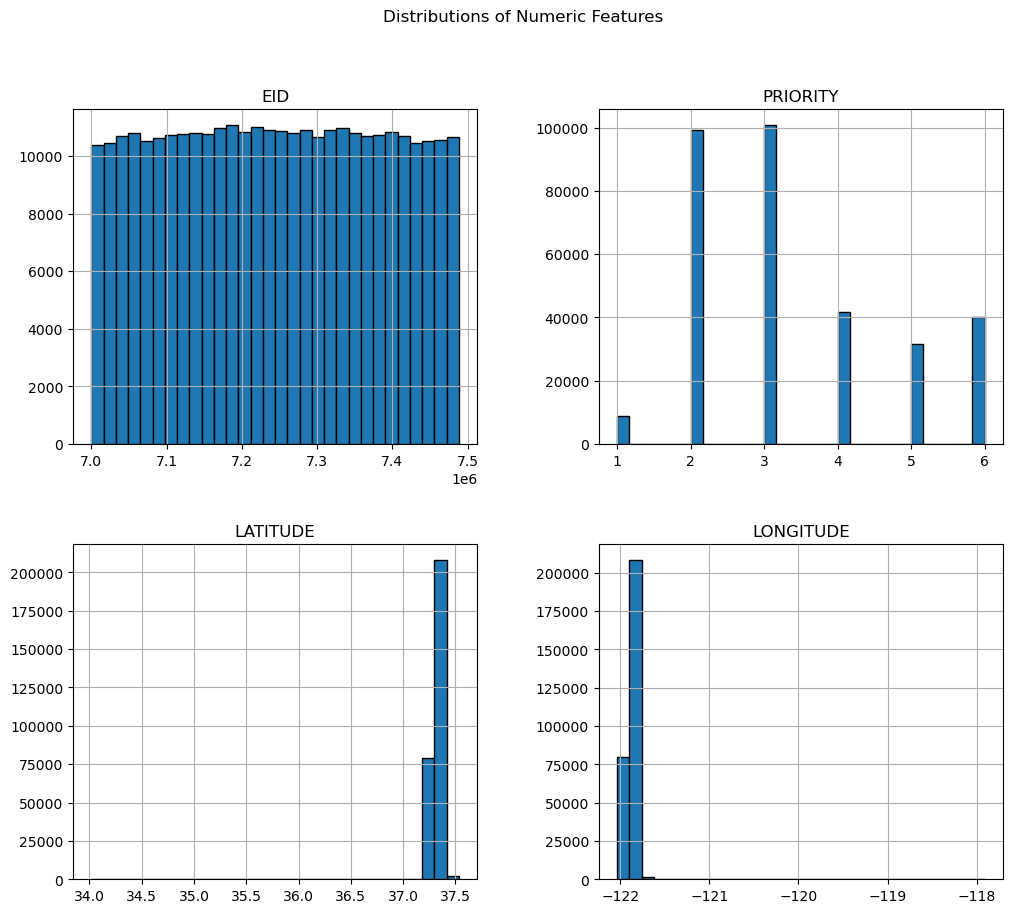

In [13]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [14]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               0
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              9983
CITY                    0
STATE                   0
LATITUDE            33153
LONGITUDE           33153
neighborhood        34684
dtype: int64

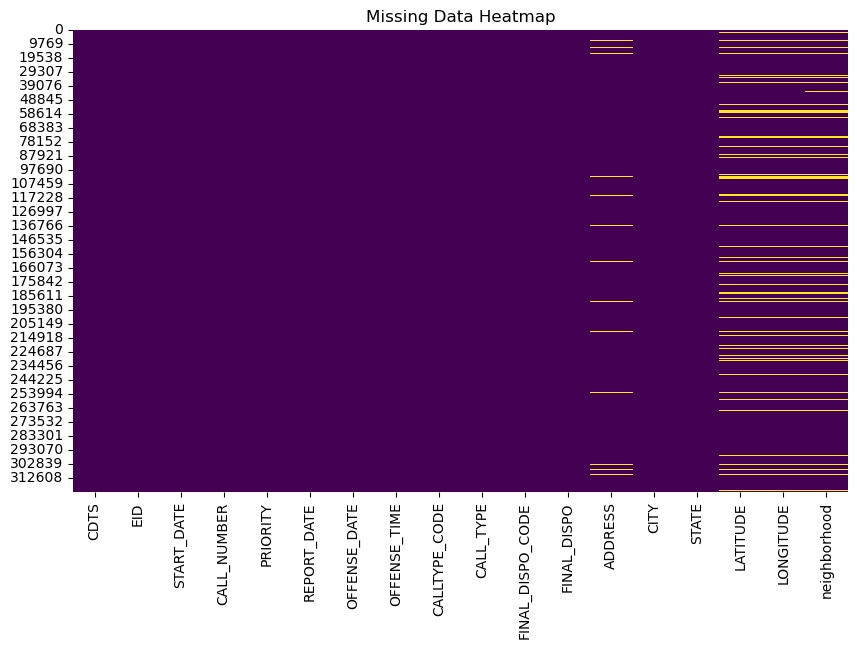

In [18]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [20]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 320127 unique values
START_DATE: 1 unique values
CALL_NUMBER: 316206 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 81044 unique values
CALLTYPE_CODE: 213 unique values
CALL_TYPE: 206 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 31667 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [21]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8599
Little Saigon and Spring Brook    5192
Trimble Business Area             4609
Five Wounds-San Jose High         4607
Steinbeck and Allen               4367
                                  ... 
San Jose Country Club               39
Alta Vista                          26
Linda Vista and Hillcrest           26
Meadowlands                         25
Santa Teresa Hills                  19
Name: count, Length: 295, dtype: int64

In [23]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          141153
CAN         42522
R           39976
G           21257
NR          13625
E           12319
D            8641
A            6429
DUPNCAN      5444
O            5245
H            4250
GD           4020
C            3854
B            3506
T            3217
U            2895
ADV          2783
F             980
M             105
Z              69
P              60
TOT            15
Name: count, dtype: int64

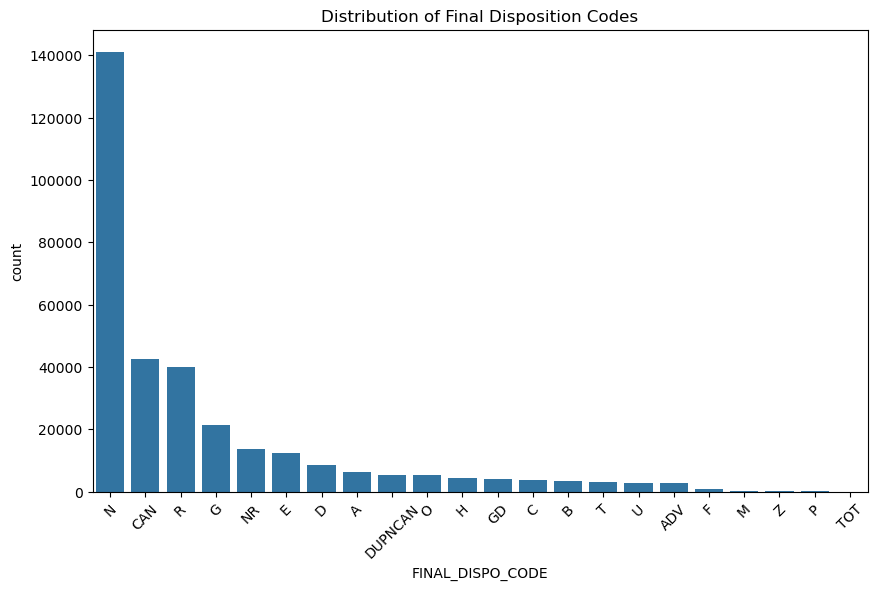

In [26]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [27]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    141153
Canceled                           42522
Report taken                       39976
Gone on Arrival/unable to loca     21257
No Response                        13625
No Disposition                     12331
Traffic Citation Issued, Non-H     12319
Traffic Citation Issued, Hazar      8641
Arrest Made                         6429
Supplemental report taken           5245
Courtesy Service/Citizen or ag      4250
Criminal Citation                   3854
Arrest by Warrant                   3506
Turned over To (TOT)                3217
Unfounded event                     2895
Field Interview (F.I.) Complet       980
Stranded motorist assist             105
Prior case, follow-up activity        60
Name: count, dtype: int64

In [28]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'N': 'No report required; dispatch r',
 'NR': 'No Response',
 'CAN': 'Canceled',
 'R': 'Report taken',
 'G': 'Gone on Arrival/unable to loca',
 'H': 'Courtesy Service/Citizen or ag',
 'GD': 'No Disposition',
 'DUPNCAN': 'No Disposition',
 'O': 'Supplemental report taken',
 'T': 'Turned over To (TOT)',
 'A': 'Arrest Made',
 'U': 'Unfounded event',
 'B': 'Arrest by Warrant',
 'E': 'Traffic Citation Issued, Non-H',
 'ADV': 'No Disposition',
 'D': 'Traffic Citation Issued, Hazar',
 'C': 'Criminal Citation',
 'F': 'Field Interview (F.I.) Complet',
 'Z': 'No Disposition',
 'M': 'Stranded motorist assist',
 'P': 'Prior case, follow-up activity',
 'TOT': 'No Disposition'}

In [29]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'FDAID': 'FIRE DEPARTMENT REQUEST FOR PD',
 '1033A': 'ALARM, AUDIBLE',
 '415M': 'DISTURBANCE, MUSIC',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '1057': 'FIREARMS DISCHARGED',
 'DVRO': 'VIOLATION OF PROTECTIVE ORDER',
 '415': 'DISTURBANCE',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAM',
 '5150': 'MENTALLY DISTURBED PERSON',
 '23103': 'RECKLESS DRIVING',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '242': 'BATTERY',
 '415F': 'DISTURBANCE, FAMILY',
 '10851': 'STOLEN VEHICLE',
 'AID': 'PUBLIC SAFETY ASSISTANCE',
 '1070': 'PROWLER',
 '415W': 'DISTURBANCE, WEAPON',
 '1066': 'SUSPICIOUS PERSON',
 'WELCK': 'WELFARE CHECK',
 '415A': 'DISTURBANCE, FIGHT',
 '911UNK': 'UNK TYPE 911 CALL',
 '1195': 'VEHICLE STOP',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '415AEMS': 'DISTURBANCE, FIGHT (COMBINED E',
 '1125': 'TRAFFIC HAZARD',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '1091C': 'INJURED ANIMAL',
 '246': 'SHOOTING INTO OCCP VEH OR DWEL',
 '23152': 'MISDEMEANOR DUI',
 '1091A': 'VICIOUS ANIMAL',
 '6F': 'FELONY WANT',
 '484

## Focus on Target Dispositions

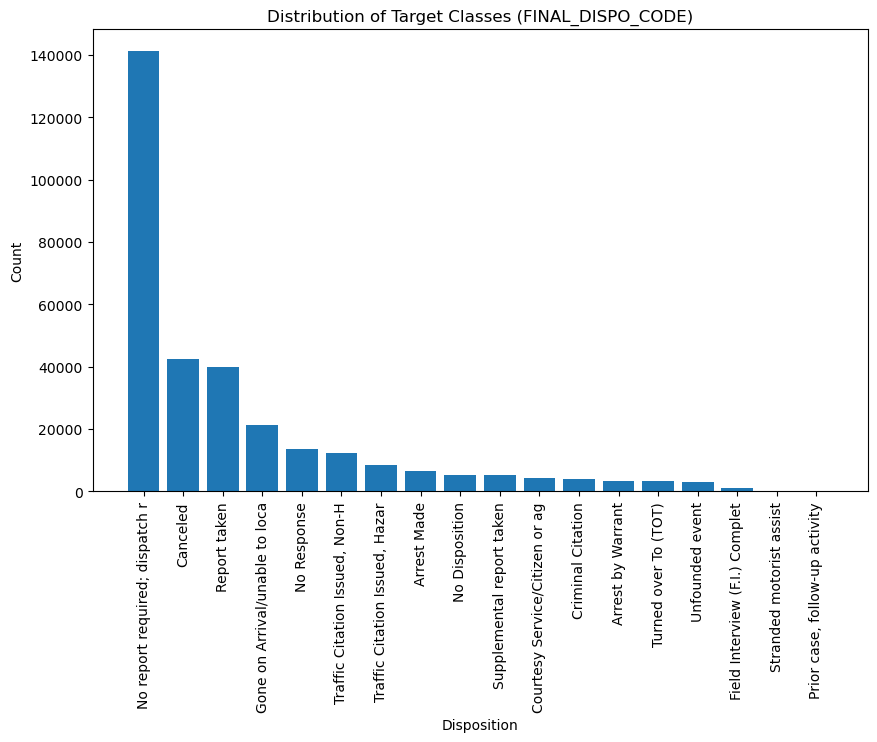

In [31]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [32]:
model_utils.transform_offense_date(all_police_df)

In [33]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    308576
A          6429
C          3854
B          3506
Name: count, dtype: int64

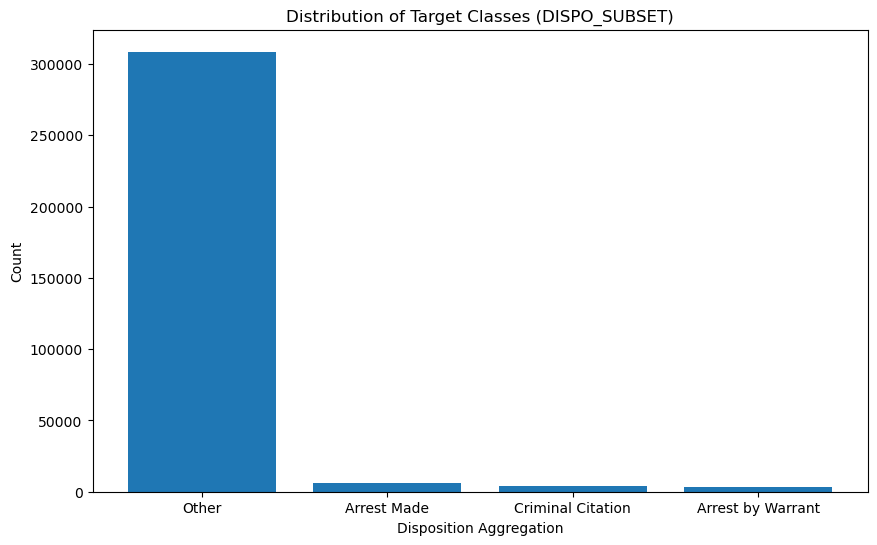

In [34]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

## Data Cleaning and Feature Engineering

In [37]:
encoder = joblib.load('one_hot_encoder.pkl')

In [41]:
police_calls_encoded, _ = model_utils.clean_and_transform_data(all_police_df, encoder)
police_calls_encoded.shape

Police Calls Dataset: 322365 rows before cleaning, 287681 rows after cleaning.


(287681, 535)

## Define X and Y

In [48]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled = \
    model_utils.split_data(police_calls_encoded, dispo_mapping)

classes = ['A' 'B' 'C' 'Other']
(230144, 534)
(57537, 534)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 220182, 0: 4670, 2: 2786, 1: 2506})
Counter({3: 9962, 0: 4670, 2: 2786, 1: 2506})


y_train distribution: Counter({3: 220182, 0: 4670, 2: 2786, 1: 2506})
y_test distribution: Counter({3: 55046, 0: 1168, 2: 697, 1: 626})
y_train_resampled distribution: Counter({3: 220182, 0: 4670, 2: 2786, 1: 2506})


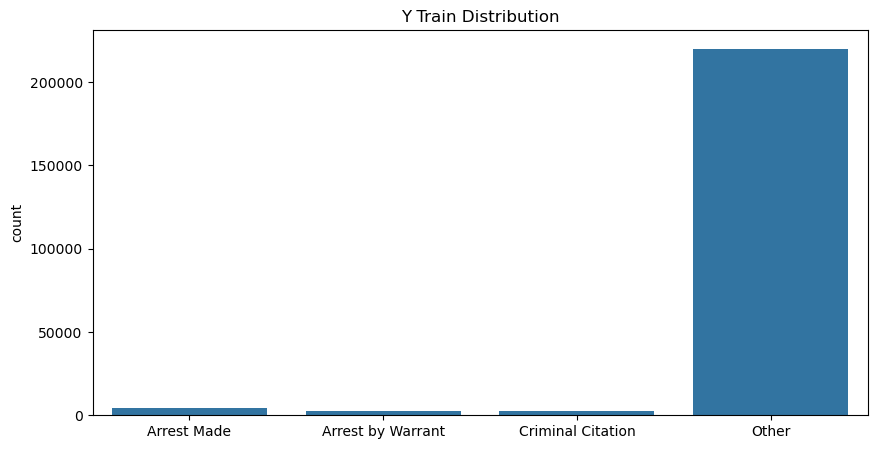

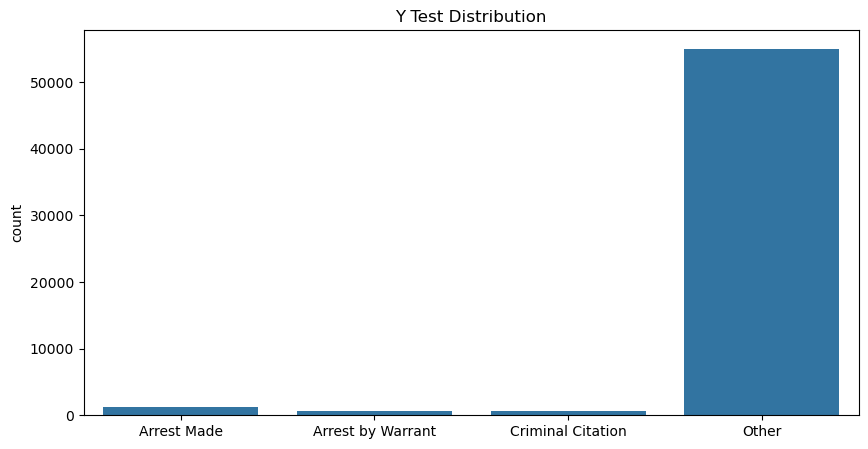

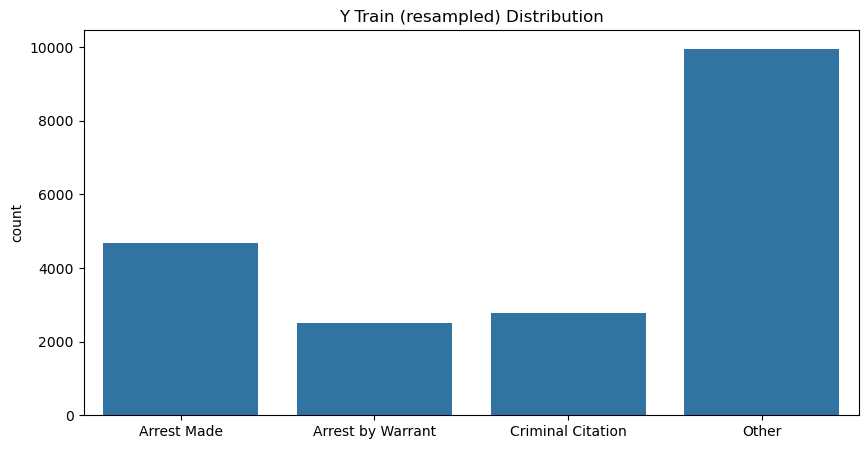

In [53]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [56]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [57]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [58]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00      1168
Arrest by Warrant       0.00      0.00      0.00       626
Criminal Citation       0.00      0.00      0.00       697
            Other       0.96      1.00      0.98     55046

         accuracy                           0.96     57537
        macro avg       0.24      0.25      0.24     57537
     weighted avg       0.92      0.96      0.94     57537



### Logistic Regression

In [61]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [62]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [63]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.17      0.63      0.26      1168
Arrest by Warrant       0.30      0.60      0.40       626
Criminal Citation       0.15      0.45      0.23       697
            Other       0.99      0.89      0.94     55046

         accuracy                           0.88     57537
        macro avg       0.40      0.64      0.46     57537
     weighted avg       0.95      0.88      0.91     57537



#### Hyperparameter Tuning

In [65]:
grid_search_scoring_method = 'f1_macro'

In [66]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

# Initialize Grid Search
# make sure n_jobs is reasonable so my machine doesn't run out of memory
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=5, n_jobs=3, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=3, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [67]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 0.1}
Best Score (f1_macro): 0.5677


In [69]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2018/best_logistic_regression.pkl']

In [70]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [71]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.61      0.30      0.41      1168
Arrest by Warrant       0.70      0.54      0.61       626
Criminal Citation       0.46      0.16      0.24       697
            Other       0.97      0.99      0.98     55046

         accuracy                           0.97     57537
        macro avg       0.69      0.50      0.56     57537
     weighted avg       0.96      0.97      0.96     57537



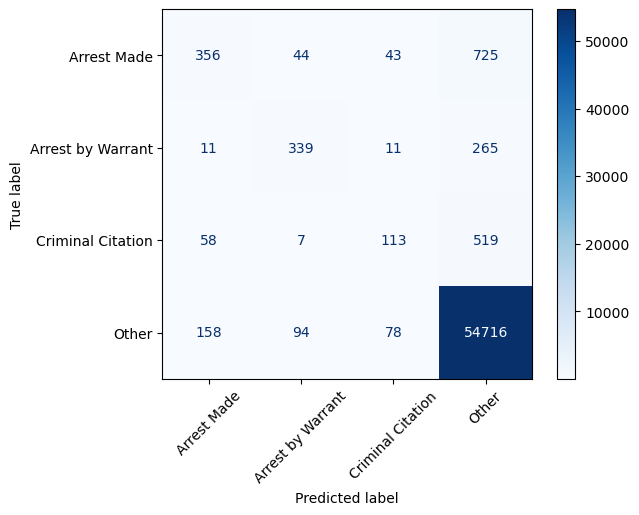

In [76]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [78]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [79]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [80]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                     Feature  Importance  \
205                         CALLTYPE_CODE_6M    0.006518   
189                       CALLTYPE_CODE_601T    0.004374   
64                       CALLTYPE_CODE_11300    0.002781   
204                         CALLTYPE_CODE_6F    0.002549   
201                       CALLTYPE_CODE_647F    0.001651   
69                       CALLTYPE_CODE_11377    0.001622   
170                        CALLTYPE_CODE_484    0.001419   
112                      CALLTYPE_CODE_23152    0.001275   
89                       CALLTYPE_CODE_14601    0.001101   
49                      CALLTYPE_CODE_10851R    0.001043   
119                        CALLTYPE_CODE_242    0.000782   
91                         CALLTYPE_CODE_148    0.000753   
107                      CALLTYPE_CODE_22500    0.000550   
80                        CALLTYPE_CODE_1195    0.000521   
199                       CALLTYPE_CODE_647B    0.000492   
180                       CALLTYPE_CODE_

In [81]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                  Display Name  Coefficient
49         Call Type: RECOVERED STOLEN VEHICLE     0.406294
107               Call Type: PARKING VIOLATION    -0.314229
13                   Call Type: ALARM, AUDIBLE    -0.295136
112                 Call Type: MISDEMEANOR DUI     0.270641
189                   Call Type: TRUANT (TABS)     0.265993
231   Call Type: VIOLATION OF PROTECTIVE ORDER     0.231581
47                   Call Type: STOLEN VEHICLE     0.213328
212               Call Type: UNK TYPE 911 CALL    -0.202221
165                  Call Type: BURGLARY (460)     0.195026
180       Call Type: MENTALLY DISTURBED PERSON     0.191296
81           Call Type: VEHICLE STOP ON FEMALE    -0.161817
181       Call Type: MENTALLY DISTURBED FEMALE     0.159104
167                Call Type: VEHICLE BURGLARY     0.153330
146             Call Type: DISTURBANCE, FAMILY     0.152240
63                   Call Type: TRAFFIC HAZARD    -0.150110
125      Call Type:

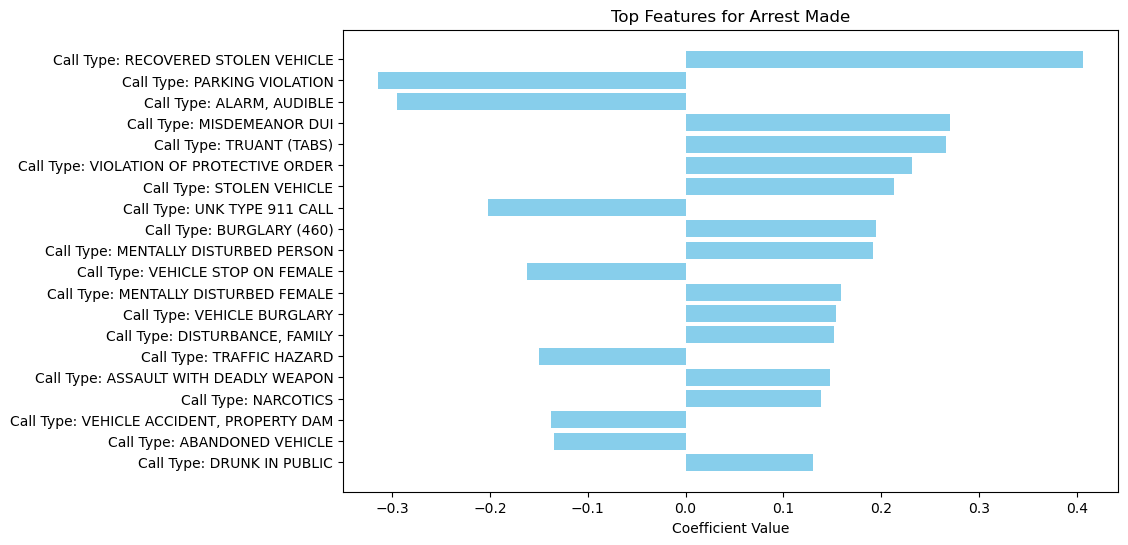

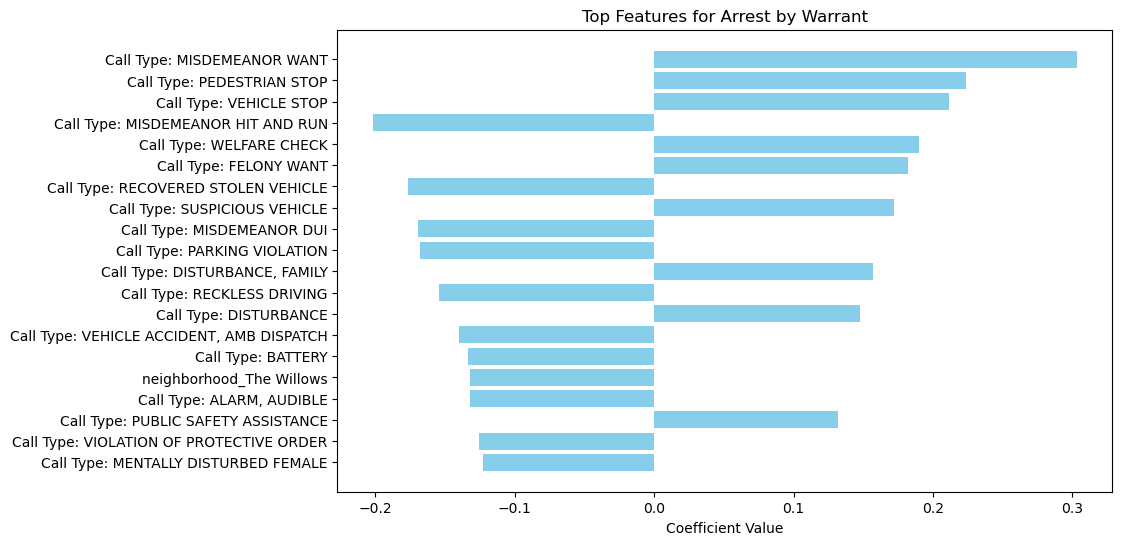

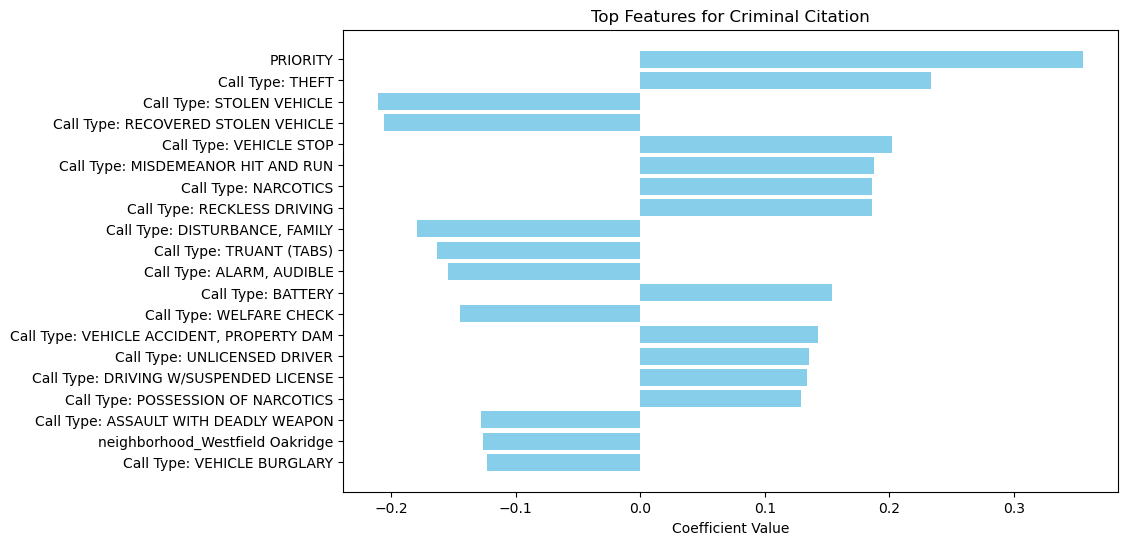

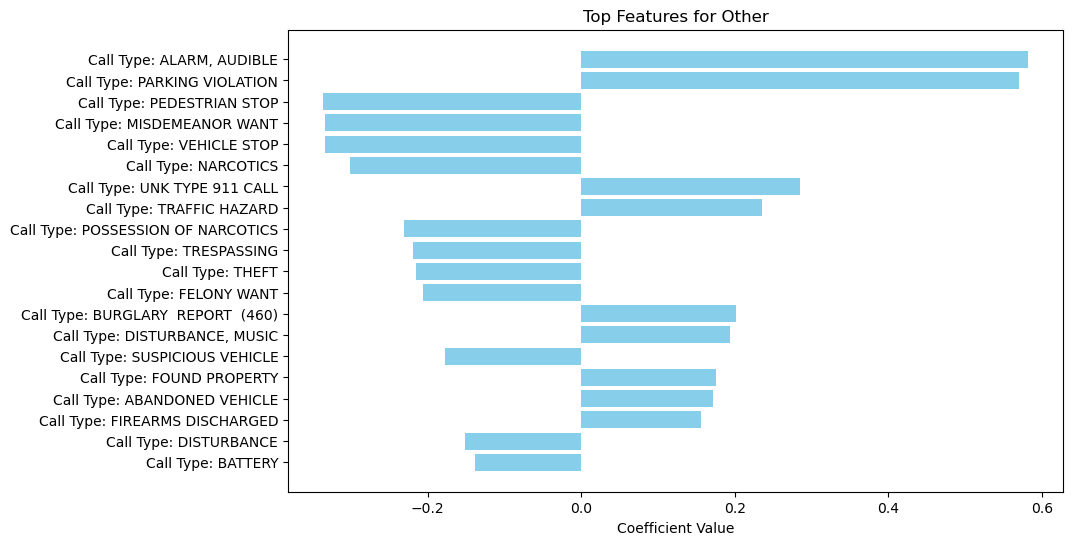

In [82]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [84]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [85]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.52      0.30      0.38      1168
Arrest by Warrant       0.63      0.48      0.55       626
Criminal Citation       0.35      0.19      0.25       697
            Other       0.97      0.99      0.98     55046

         accuracy                           0.96     57537
        macro avg       0.62      0.49      0.54     57537
     weighted avg       0.95      0.96      0.96     57537



#### Hyperparameter Tuning and Cross Validation

In [87]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=5,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 60}
Best Score (f1_macro): 0.56


In [88]:
best_rf = grid_rf.best_estimator_

In [89]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2018/best_random_forest.pkl']

In [90]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [91]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.54      0.31      0.39      1168
Arrest by Warrant       0.64      0.49      0.55       626
Criminal Citation       0.36      0.18      0.24       697
            Other       0.97      0.99      0.98     55046

         accuracy                           0.96     57537
        macro avg       0.63      0.49      0.54     57537
     weighted avg       0.95      0.96      0.96     57537



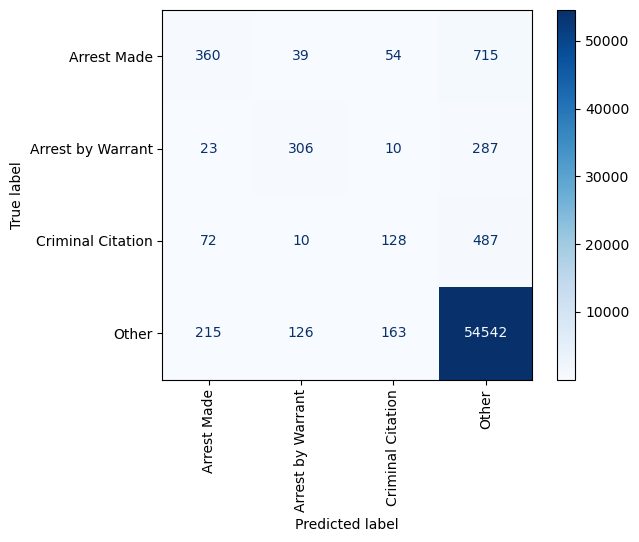

In [92]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

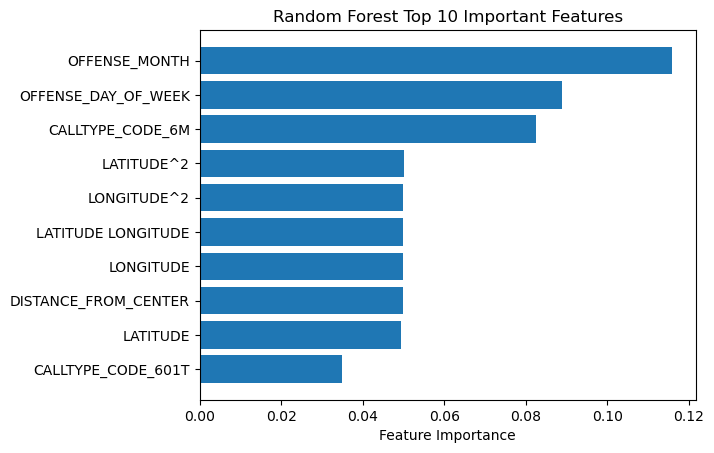

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Top 10 Important Features')
plt.show()

### Multilayer Perceptron Model

In [100]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [101]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=5,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [102]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [103]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9553 - loss: 0.1943 - val_accuracy: 0.9659 - val_loss: 0.1312
Epoch 2/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9636 - loss: 0.1399 - val_accuracy: 0.9658 - val_loss: 0.1314
Epoch 3/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9639 - loss: 0.1340 - val_accuracy: 0.9659 - val_loss: 0.1298
Epoch 4/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9644 - loss: 0.1319 - val_accuracy: 0.9657 - val_loss: 0.1317
Epoch 5/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9635 - loss: 0.1311 - val_accuracy: 0.9643 - val_loss: 0.1368
Epoch 6/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9656 - loss: 0.1247 - val_accuracy: 0.9650 - val_loss: 0.1336
Epoch 7/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9662 - loss: 0.1202 - val_accuracy: 0.9622 - val_loss: 0.1380
Epoch 8/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9660 - loss: 0.1202 - 

In [104]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2018/mlp_model.pkl']

In [105]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [106]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 1s 458us/step - accuracy: 0.9641 - loss: 0.1378
Test Accuracy: 0.9641


In [107]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.67      0.24      0.35      1168
Arrest by Warrant       0.70      0.54      0.61       626
Criminal Citation       0.54      0.07      0.13       697
            Other       0.97      1.00      0.98     55046

         accuracy                           0.96     57537
        macro avg       0.72      0.46      0.52     57537
     weighted avg       0.96      0.96      0.96     57537



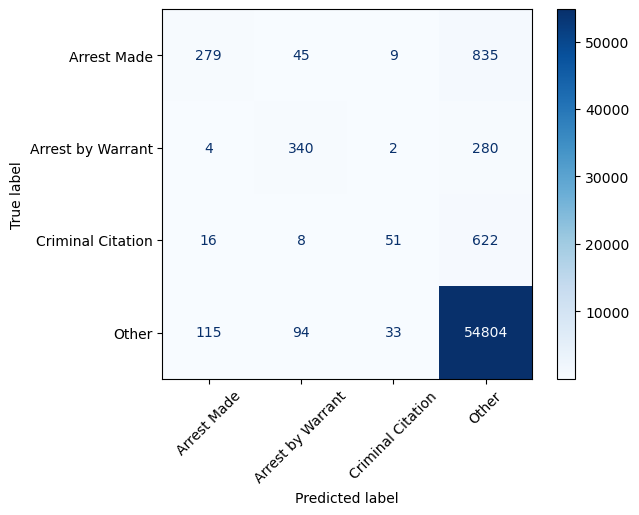

In [108]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [111]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-04 11:46:58,439] A new study created in memory with name: no-name-6f8a1a8b-a3dc-40ae-8bd2-0c9caf2cfd76
[I 2024-10-04 11:47:26,793] Trial 0 finished with value: 0.6733971273810726 and parameters: {'n_estimators': 402, 'learning_rate': 0.02441777351667601, 'max_depth': 7, 'subsample': 0.6659935889393813, 'colsample_bytree': 0.8009150165507343, 'gamma': 1.0937604275757077e-06, 'reg_alpha': 3.1391830956914746e-08, 'reg_lambda': 2.064156347858095e-06}. Best is trial 0 with value: 0.6733971273810726.
[I 2024-10-04 11:48:17,010] Trial 1 finished with value: 0.6351569766678906 and parameters: {'n_estimators': 448, 'learning_rate': 0.0017756014383028722, 'max_depth': 10, 'subsample': 0.8187610206989586, 'colsample_bytree': 0.8563342579222374, 'gamma': 0.004939670041854274, 'reg_alpha': 0.01148485073425693, 'reg_lambda': 1.3946522551776682e-06}. Best is trial 0 with value: 0.6733971273810726.
[I 2024-10-04 11:48:35,191] Trial 2 finished with value: 0.6725996660072939 and parameters: {

Actual runtime: 510.39 seconds (8.51 minutes)
Best parameters found:  {'n_estimators': 401, 'learning_rate': 0.05939517368192729, 'max_depth': 5, 'subsample': 0.600743054957907, 'colsample_bytree': 0.7498375995472688, 'gamma': 0.006349171877642298, 'reg_alpha': 0.0003129198997420522, 'reg_lambda': 4.83986527390552e-05}
Best F1 macro score:  0.6823635919290727


In [112]:
# Train the final model with the best parameters:
best_params = study.best_params
best_model = XGBClassifier(**best_params, eval_metric='logloss')
best_model.fit(X_train, y_train)
xgb_1_model = best_model
xgb_1_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7498375995472688, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.006349171877642298, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05939517368192729, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=401, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [113]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.65      0.30      0.41      1168
Arrest by Warrant       0.69      0.53      0.60       626
Criminal Citation       0.49      0.19      0.27       697
            Other       0.97      0.99      0.98     55046

         accuracy                           0.97     57537
        macro avg       0.70      0.51      0.57     57537
     weighted avg       0.96      0.97      0.96     57537



In [114]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2018/xgb_model.pkl']

In [115]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [117]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [118]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.5602058634057996
RF F1: 0.5424947922919726
XGB F1: 0.5689177523081227


In [119]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

#### Stacking #1

In [121]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=5)
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7498375995472688,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,...
                                              learning_rate=0.05939517368192729,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=401, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression(), n_jobs=5)

In [122]:
joblib.dump(stacking_clf, f"models/{year}/stacking_1.pkl") 

['models/2018/stacking_1.pkl']

In [123]:
stacking_clf = joblib.load(f"models/{year}/stacking_1.pkl")

In [124]:
y_pred_stacking_1 = stacking_clf.predict(X_test)
stack_1_accuracy = accuracy_score(y_test, y_pred_stacking_1)
stack_1_recall = recall_score(y_test, y_pred_stacking_1, average='macro')
stack_1_prec = precision_score(y_test, y_pred_stacking_1, average='macro')
stack_1_f1 = f1_score(y_test, y_pred_stacking_1, average='macro')
print(f"Stacking Classifier F1 Score: {stack_1_f1}")

Stacking Classifier F1 Score: 0.5657442812223515


#### Stacking #2

In [126]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=5)
stacking_clf_2.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7498375995472688,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=5)

In [127]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2018/stacking_2.pkl']

In [128]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [129]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.5837143894991831


## Results

In [131]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Stack 1', 'Stack 2'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.956706,0.250000,0.239177,0.244469
Logistic Regression,0.965014,0.500614,0.686358,0.560206
Random Forest,0.961746,0.492881,0.626869,0.542495
MLP,0.964145,0.462694,0.719547,0.518683
XGB,0.965674,0.505501,0.701881,0.568918
Stack 1,0.965379,0.503643,0.688391,0.565744
Stack 2,0.965518,0.525273,0.688124,0.583714


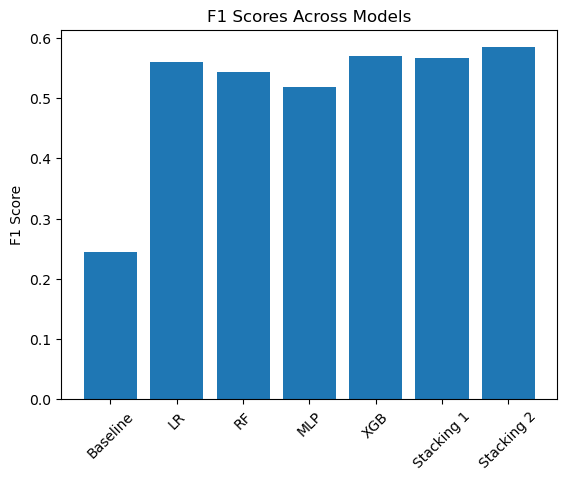

In [132]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Stacking 1', 'Stacking 2']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Compare with the All-Year Models

In [134]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [135]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

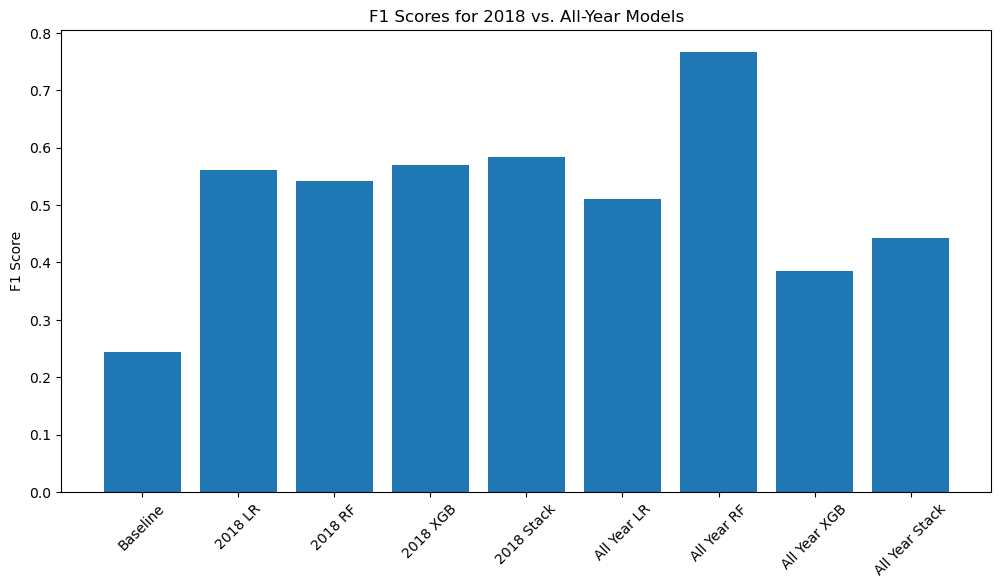

In [191]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()